```
@beelzebruno
2022
```

In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from src.heuristics import highlands_distances as knowledge_base



plt.style.use('seaborn')

# Highlands

Do you remember highlands from [graph_search notebook](https://github.com/brunolcarli/GooGraph/blob/master/graph_search.ipynb)? Lets play again with it, with different approaches
on graph searching.

![highlands_map](https://github.com/brunolcarli/GooGraph/blob/master/static/img/highlands_map.png?raw=true)

<br />


This time I have decided to keep the heuristics in a `src` folder so long dicts
of distances dont flood the notebook viewing. Data structures, and algorithms
for practice questions of course, are all always rewritten...

<br />

This time I will name our *node* structure as `HeuristicNode` since it receives
a `dict` containig information about its edges, in other words, the node is
initialized knowing its connections and the traveling distance cost to move from
current position to the adjacent node through the edge:

In [151]:
class HeuristicNode:
    """
    A node that contains information about its edges.
    """
    def __init__(self, name, heuristic):
        self.name = name
        self.heuristic = heuristic[name]

    def __repr__(self):
        return f'Node: {self.name}'

    def reachable(self, node):
        """
        Return True if it is possible to move from current node to argument node
        """
        return node.name in self.heuristic

    def distance_to(self, node):
        """ Return distance to argument node based on heuristics """
        return self.heuristic[node.name]



The `Graph` structure is static, because it represents a known world from the
heuristic `dict` information previously defined.

<br />

And the `Cursor` structure that you should remember from [Beer Route notebook](https://github.com/brunolcarli/GooGraph/blob/master/Beer_route.ipynb), which is a controller structure built to
move around the graph, node by node.

In [152]:
class Graph:
    def __init__(self, heuristic):
        self.heuristic = heuristic
        self.nodes = self.make_nodes(heuristic)

    def __repr__(self):
        return ' | '.join(node.name for node in self.nodes)

    def make_nodes(self, content):
        """ Build Nodes based on heuristic information """
        if not content:
            return {}

        return {name: HeuristicNode(name, self.heuristic) for name in content}


class Cursor:
    """
    Cursor is a control structure to move around nodes in a graph.
    """
    def __init__(self, graph, start):
        self.graph = graph
        self.current = start
        self.root = start
        self.before = None

        self.effort = 0
        self.total_distance = 0
        self.total_moves = 0

    def __repr__(self):
        if self.before is None:
            return f'Cursor at start position {self.current}'
        return f'Cursor at {self.current} from {self.before}'

    def move(self, node):
        """ Move to an adjacent Node. """
        if not self.current.reachable(node):
            raise Exception('Cannot move to that position!')

        self.before = self.current
        self.total_distance += self.current.distance_to(node)
        self.current = node
        self.effort += 1
        self.total_moves += 1

        return self

Differently form the *probe* I have implemented on Beer Route, this time i will
name our cursor extension as `Agent` following an Russel and Norvig approach,
where the definition setled by the authors is that "an **agent** is everything
that can be considered able to percept its **environment** from **sensors** and
act over this environment by use of **actuators**."

In this case, our `Agent` is an implementation extended from `Cursor`, our
environment is the `Graph`. The agent is able to percept the environment by
inspecting its current node heuristic and the `move()` method is th actuation
feature which makes possible to the agent walk (action) around the environment.

<br />

The Russell and Norvig approach also points to concepts of rationality, which
are defined by the authors in four statements:

- **The performance measurement that define the succes criteria**

Our agent performance will be measured here by the following variables:

    - Total distance traveled;
    - Total movements (steps) executed by the agent;
    - Total computional effort spent in the process;

- **The previous knowledge agent has about the environment**

This is possible trhough the heuristic information from both graph and and
current node, by knowing:

    - Distance from current node to target node;
    - Reachability (The agent is able to move from current position to target position?)

- **The actions our agent can perform**

Our agent will be able to execute two actions:

    - Move from one node to another;
    - Calculate the best next step;

- **The perceptions sequence the agent got until the present moment**

Our agent wll store:

    - Current position;
    - Previous position;
    - Movements executed;
    - Distance traveled;
    - History log of movements (from Node X to Node Y)

The probe implemented in beer route used sorting algorithms to simply take
the routhe with lower distance, but the Highlands have a different graph connection
structure, not all nodes connect with each other, so the agent must **search**
a path that it can follow, and of course, with the lowest distance possible.

I intend to make something like "mind projection" or even a "reflexion" abstraction
to implement the choice of the best next movement. The idea is to make the agent
"think" about all current possibilities and the distance to the target from each
possibility, so it will run a search algorithm for each possibility to calculate
the distance it will cost to the target. The best option of course is the edge
wich the search returned the lower distance.

<br />

To keep the code a little bit more lean I decided to implement different classes
to encapsulate methods specific for the search methods in a `SearchLib` so our
agent can inherit the methods from it.

In [140]:
class Pointer:
    """ Simple 'List' structure to store a node and its origin """
    def __init__(self, data, previous=None):
        self.data = data
        self.previous = previous


class SearchLib:
    """
    Contain search algorthm methods.
    Inherit this class in a Cursor like structure.
    """
    @property
    def search_methods(self):
        return {
            'bfs': self.breadth_first_search,
            'dfs': self.depth_first_search,
            'a_star': self.a_star_search,
            'dijkstra': self.dijkstra_search
        }

    def breadth_first_search(self, start_node, target_node, traveled_distance):
        # TODO: Implement queue from scratch to self exercise
        queue = [Pointer(start_node, start_node)]
        total_distance = traveled_distance
        effort = 0

        while queue:
            node = queue.pop(0)
            total_distance += node.previous.distance_to(node.data)
            options = node.data.heuristic

            if node.data.name == target_node.name:
                return start_node, total_distance, effort

            for option in options:
                # Option is a pointer which stores the option and father node
                queue.append(Pointer(self.graph.nodes[option], node.data))
                effort += 1

        return start_node, total_distance, effort

    def depth_first_search(self, initial_options, target_node):
        raise Exception('Not implemented...')

    def a_star_search(self, initial_options, target_node):
        raise Exception('Not implemented...')

    def dijkstra_search(self, initial_options, target_node):
        raise Exception('Not implemented...')
    

The `Agent` must be able to find and move to target node autonomously, so it
will implement a `run()` method that receive a `strategy` parameter to define
the search engnie used to select the best next node and move itself over the
graph until it reaches the target.

In [153]:
class Agent(Cursor, SearchLib):
    """ Automate rational agent to find a path to a target place """
    def __init__(self, graph, start_node, target_node):
        super().__init__(graph, start_node)
        self.history = [(str(self), self.effort, self.total_distance, self.total_moves)]
        self.target_node = target_node

    @property
    def options(self):
        """ Return possible nodes to move """
        return self.current.heuristic

    def run(self, strategy='bfs'):
        """
        Agent finds by itself the best route to target and move itself
        over the graph node by node to reach the target node.
        """
        while self.current.name != self.target_node.name:
            next_node = self.search_best_option(strategy)
            if next_node:
                self.move(next_node)
            else:
                break
        return self

    def move(self, node):
        """ Move from current node to argument node """
        super(Agent, self).move(node)  # extends from superclass
        self.history.append((str(self), self.effort, self.total_distance, self.total_moves))
        return self

    def search_best_option(self, strategy='bfs'):
        """ Search a best next position towards the target """
        if strategy not in self.search_methods:
            raise Exception(f'Invalid search strategy: {strategy}!')

        options = [self.graph.nodes[node] for node in self.options
                   if node not in self.history]
        if not options:
            return

        # We will search the total distance to target from each available option
        distances_by_option = []
        for option in options:
            distances_by_option.append(
                self.search_methods[strategy](
                    option,
                    self.target_node,
                    self.total_distance
                    )
                )
            self.effort += 1

        # sort the results by minimum distance. The best option will be the first
        # TODO write a scratch sort engine just like the searches
        sorted_distances = sorted(distances_by_option, key=lambda v: v[1])
        best, _, effort = sorted_distances[0]
        self.effort += effort
        return best


In [154]:
# Driver code
START = 'Case Town'
TARGET = 'Vault Gisley'

highlands = Graph(knowledge_base)
cursor = Agent(highlands, highlands.nodes[START], highlands.nodes[TARGET])
cursor.run()

highlands_bfs_df = pd.DataFrame(
    cursor.history,
    columns=['State', 'Effort', 'Distance traveled', 'Cursor movements']
)
highlands_bfs_df

,State,Effort,Distance traveled,Cursor movements
0,Cursor at start position Node: Case Town,0,0,0
1,Cursor at Node: Por Town from Node: Case Town,434,322,1
2,Cursor at Node: Sonospla from Node: Por Town,564,1112,2
3,Cursor at Node: Desert Fortress from Node: Son...,597,1192,3
4,Cursor at Node: Vault Gisley from Node: Desert...,604,1492,4


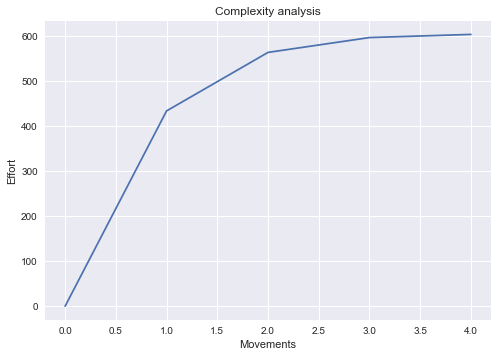

In [156]:
plt.plot(highlands_bfs_df['Cursor movements'].values, highlands_bfs_df['Effort'].values)
plt.title('Complexity analysis')
plt.xlabel('Movements')
plt.ylabel('Effort')
plt.show()